In [1]:
import sys
from os.path import isfile
from os.path import join

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import scipy
from scipy import stats
from scipy import optimize as opt
from scipy.signal import savgol_filter

import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Nadam

from tensorflow_addons.metrics import F1Score


# My packages
sys.path.insert(0, "../scs/")
import data_degrading as dd
import data_preparation as dp
import data_augmentation as da
from prepare_datasets_for_training import extract
import data_plotting as dplt
import scs_config

sys.path.insert(0, "../scs/models/")
import feed_forward
import transformer_encoder

from icecream import ic
from importlib import reload

rng = np.random.RandomState(1415)

In [2]:
# Bianco noise
def invertrfftfreq(x, bs):
    """ this utility function helps making the x axis in the plots interpretable; invert rfft"""
    freq = np.fft.rfftfreq(len(x))
    N = len(freq) * 2
    if len(x) % 2:
        return np.arange(0, max(freq * N * bs) * 2, bs)
    else:
        return np.arange(0, max(freq * N * bs) * 2 - 2 * bs, bs)


def binspec(wvl, flux, wstart, wend, wbin):
    nlam = (wend - wstart) / wbin + 1
    nlam = int(np.ceil(nlam))
    outlam = np.arange(nlam) * wbin + wstart
    answer = np.zeros(nlam)
    interplam = np.unique(np.concatenate((wvl, outlam)))
    interpflux = np.interp(interplam, wvl, flux)

    for i in np.arange(0, nlam - 1):
        cond = np.logical_and(interplam >= outlam[i], interplam <= outlam[i+1])
        w = np.where(cond)
        if len(w) == 2:
            answer[i] = 0.5*(np.sum(interpflux[cond])*wbin)
        else:
            answer[i] = scipy.integrate.simps(interpflux[cond], interplam[cond])

    answer[nlam - 1] = answer[nlam - 2]
    cond = np.logical_or(outlam >= max(wvl), outlam < min(wvl))
    answer[cond] = 0
    return answer/wbin, outlam


def preppowerlaw(wvl, flux, cut_vel, c_kms, vel_toosmall, vel_toolarge, plot=False):
    """this function contains functionality for noise extraction in common for the SNID and non SNID case"""
    wvl_ln = np.log(wvl)  # log base e
    binsize = wvl_ln[-1] - wvl_ln[-2]  # equal bin size in log space

    f_bin, wln_bin = binspec(wvl_ln, flux, min(wvl_ln), max(wvl_ln), binsize)  # binned spectrum

    fbin_ft = np.fft.fft(f_bin)  # *len(f_bin) # real fft of the binned spectrum
    freq = np.fft.fftfreq(wln_bin.shape[0], binsize)  # 1 / ln(wavelength)
    indx = np.arange(1, freq.shape[0] // 2)
    ps = np.abs(fbin_ft[indx])  # magnitude of the power spectrum = sqrt(P)

    # Dlambda/lambda = v/c
    freq_natural_units = freq / c_kms  # * binsize

    num_upper = np.arange(len(freq))[1.0 / freq_natural_units >= vel_toosmall][-1]
    num_lower = np.arange(len(freq))[1.0 / freq_natural_units <= vel_toolarge][0]
    mag_avg = np.mean(ps[num_lower:num_upper])

    # power spectrum in the signal region
    xps = freq[num_lower:num_upper]
    yps = ps[num_lower:num_upper]

    finite_mask = np.logical_not(ps == 0)
    finite_mask = np.logical_and(finite_mask, np.isfinite(ps))
    if finite_mask.sum() == 0:
        print("no good data points here")
        return None, None, None, None, None, None, None, None, None


    powerlaw = lambda x, amp, exp: amp * x ** exp

    # TODO FBB: these should not be hard coded
    exp_guess = 2  # *slope -hard coded atm
    amp_guess = 800  # np.exp(intercept) hard coded atm

    ampfit, expfit = opt.curve_fit(
        powerlaw,
        freq[indx][finite_mask],
        ps[finite_mask],  # sigma=np.sqrt(freq[indx][finite_mask]),
        p0=[amp_guess, exp_guess],
    )[0]

    # TODO FBB: this should be cleaner - ATM returning everything _and_ the kitchen sink

    return mag_avg, ampfit, expfit, fbin_ft, wln_bin, xps, yps, freq, f_bin


def smooth(wvl, flux, cut_vel, snidified=True, sv=None):
    c_kms = 299792.47  # speed of light in km/s
    vel_toosmall = 3_000
    vel_toolarge = 100_000

    # common preprocessing for SNID and non SNID spectra
    mag_avg, ampfit, expfit, fbin_ft, wln_bin, xps, yps, freq, f_bin = preppowerlaw(wvl, flux, cut_vel, c_kms, vel_toosmall, vel_toolarge)
    if mag_avg is None:
        return wvl, flux, 0

    # find intersection of average fbin_ft magnitude and powerlaw fit to calculate
    # separation velocity between signal and noise.
    intersect_x = np.power((mag_avg / ampfit), 1.0 / expfit)
    sep_vel = 1.0 / intersect_x * c_kms

    if sv:
        sep_vel = sv  # allow sv to be passed as a user selected parameter - do that for SNID

    # filter out frequencies with velocities higher than sep_vel
    smooth_fbin_ft = fbin_ft.copy()
    noise_fbin_ft = fbin_ft.copy()
    ind = np.arange(len(freq))[1.0 / freq * c_kms >= sep_vel][-1]

    noise_fbin_ft[:ind] = 0
    smooth_fbin_ft[ind:] = 0

    smooth_fbin_ft_inv = np.real(np.fft.ifft(smooth_fbin_ft))
    noise_fbin_ft_inv = np.real(np.fft.ifft(noise_fbin_ft))

    # here is the split between SNIDified and non SNIDified spectra
    if snidified:
        amplitude = lambda y, amp: amp * y
        mask = f_bin != 0

        ampfit = opt.curve_fit(amplitude,
                               smooth_fbin_ft_inv[mask],
                               f_bin[mask],  # sigma=np.sqrt(freq[indx][finite_mask]),
                               p0=[2],
                               )[0]
        smooth_fbin_ft_inv *= ampfit
        smooth_fbin_ft_inv[~mask] = 0
        
    else:
        from scipy.interpolate import splrep, BSpline
        tck = splrep(wln_bin[:smooth_fbin_ft_inv.shape[0]],
                     f_bin[:smooth_fbin_ft_inv.shape[0]] - smooth_fbin_ft_inv, s=9)
        smooth_fbin_ft_inv += BSpline(*tck)(wln_bin[:smooth_fbin_ft_inv.shape[0]])


    w_smoothed = np.interp(wvl, np.exp(wln_bin), np.exp(wln_bin))
    f_smoothed = np.interp(wvl, w_smoothed, smooth_fbin_ft_inv)

    return w_smoothed, f_smoothed, sep_vel


def get_denoised_spectrum(wvl, flux, sv=None):
    cut_vel = 1_000  # km/s - min line velocity for SN
    wvl_smooth, flux_smooth, sepv = smooth(wvl, flux, cut_vel, sv=sv)

    assert (wvl == wvl_smooth).all(), "error in resampling spectra"

    if sepv == 0:
        print("WARNING: failed on this SN")

    return flux_smooth


def denoise_spectrum(wvl, flux):
    denoised_flux = get_denoised_spectrum(wvl, flux)
    noise = flux - denoised_flux
    return denoised_flux, noise
denoise_spectrum = np.vectorize(denoise_spectrum, signature="(n),(n)->(n),(n)")


def bianco_noise_smoothing(wvl, fluxes):
    """
    Ingest spectra, return the denoised spectra and the removed noise.
    """
    fluxes_denoised, noises = denoise_spectrum(wvl, fluxes)
    return fluxes_denoised, noises


def denoise_dataset(df):
    data = dp.extract_dataframe(df)
    index, wvl, flux_columns, metadata_columns, df_fluxes, df_metadata, fluxes = data
    fluxes_denoised, noises = bianco_noise_smoothing(wvl, fluxes)
    
    df_denoised = df.copy(deep=True)
    df_denoised[flux_columns] = fluxes_denoised

    df_noise = df.copy(deep=True)
    df_noise[flux_columns] = noises
    
    return df_denoised, df_noise


data_dir = "/home/2649/repos/SCS/data/original_resolution/preprocessed_traintestsplit"
df_P_trn = pd.read_parquet(join(data_dir, "data", "preprocessed_trn_set.parquet"))
df_P_tst = pd.read_parquet(join(data_dir, "data", "preprocessed_tst_set.parquet"))

re_smooth = False
if re_smooth:
    df_P_trn_signal, df_P_trn_noise = denoise_dataset(df_P_trn)
    df_P_tst_signal, df_P_tst_noise = denoise_dataset(df_P_tst)

    df_P_trn_signal.to_parquet(join(data_dir, "denoised/signal", "preprocessed_trn_set_signal_only.parquet"))
    df_P_tst_signal.to_parquet(join(data_dir, "denoised/signal", "preprocessed_tst_set_signal_only.parquet"))

    df_P_trn_noise.to_parquet(join(data_dir, "denoised/noise", "preprocessed_trn_set_noise_only.parquet"))
    df_P_tst_noise.to_parquet(join(data_dir, "denoised/noise", "preprocessed_tst_set_noise_only.parquet"))
else:
    df_P_trn_signal = pd.read_parquet(join(data_dir, "denoised/signal", "preprocessed_trn_set_signal_only.parquet"))
    df_P_tst_signal = pd.read_parquet(join(data_dir, "denoised/signal", "preprocessed_tst_set_signal_only.parquet"))

    df_P_trn_noise = pd.read_parquet(join(data_dir, "denoised/noise", "preprocessed_trn_set_noise_only.parquet"))
    df_P_tst_noise = pd.read_parquet(join(data_dir, "denoised/noise", "preprocessed_tst_set_noise_only.parquet"))

ic| noise_scale: 1


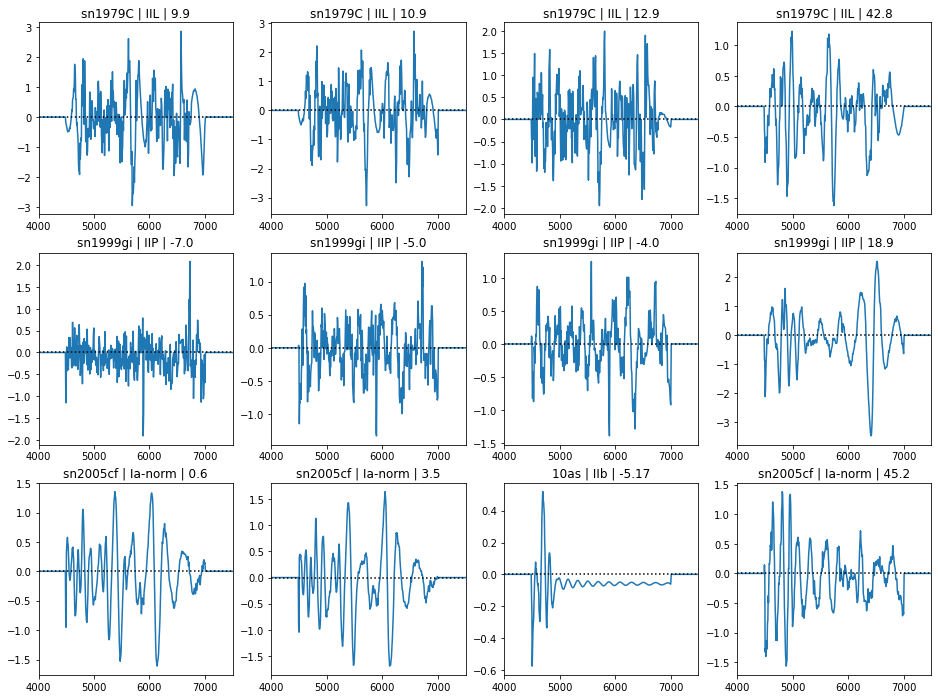

In [12]:
def get_only_self_noise(noise_scale):
    ic(noise_scale)
    
    df_P_trn_signal = pd.read_parquet(join(data_dir, "denoised/signal", "preprocessed_trn_set_signal_only.parquet"))
    df_P_tst_signal = pd.read_parquet(join(data_dir, "denoised/signal", "preprocessed_tst_set_signal_only.parquet"))
    
    df_P_trn_noise = pd.read_parquet(join(data_dir, "denoised/noise", "preprocessed_trn_set_noise_only.parquet"))
    df_P_tst_noise = pd.read_parquet(join(data_dir, "denoised/noise", "preprocessed_tst_set_noise_only.parquet"))
    
    data_trn_signal = dp.extract_dataframe(df_P_trn_signal)
    data_tst_signal = dp.extract_dataframe(df_P_tst_signal)
    
    data_trn_noise = dp.extract_dataframe(df_P_trn_noise)
    data_tst_noise = dp.extract_dataframe(df_P_tst_noise)
    
    _, _, flux_columns_trn_signal, _, _, _, fluxes_trn_signal = data_trn_signal
    _, _, flux_columns_tst_signal, _, _, _, fluxes_tst_signal = data_tst_signal
    
    _, _, flux_columns_trn_noise, _, _, _, fluxes_trn_noise = data_trn_noise
    _, _, flux_columns_tst_noise, _, _, _, fluxes_tst_noise = data_tst_noise
    
    df_trn = df_P_trn_signal.copy(deep=True)
    df_tst = df_P_tst_signal.copy(deep=True)
    
    df_trn[flux_columns_trn_signal] = noise_scale * fluxes_trn_noise
    df_tst[flux_columns_tst_signal] = noise_scale * fluxes_tst_noise
    
    return df_trn, df_tst


plot_inds = np.array([0, 1, 2, 3, 4, 5, 6, 7, 1200, 1204, 106, 1231])
xlim = (4000, 7500)

# df_trn, df_tst = get_only_self_noise(0)
# dplt.plot_specs(df_trn, plot_inds, xlim=xlim)

df_trn, df_tst = get_only_self_noise(1)
dplt.plot_specs(df_trn, plot_inds, xlim=xlim)

# df_trn, df_tst = get_only_self_noise(10)
# dplt.plot_specs(df_trn, plot_inds, xlim=xlim)

ic| noise_scale: 0
ic| noise_scale: 1
ic| noise_scale: 10


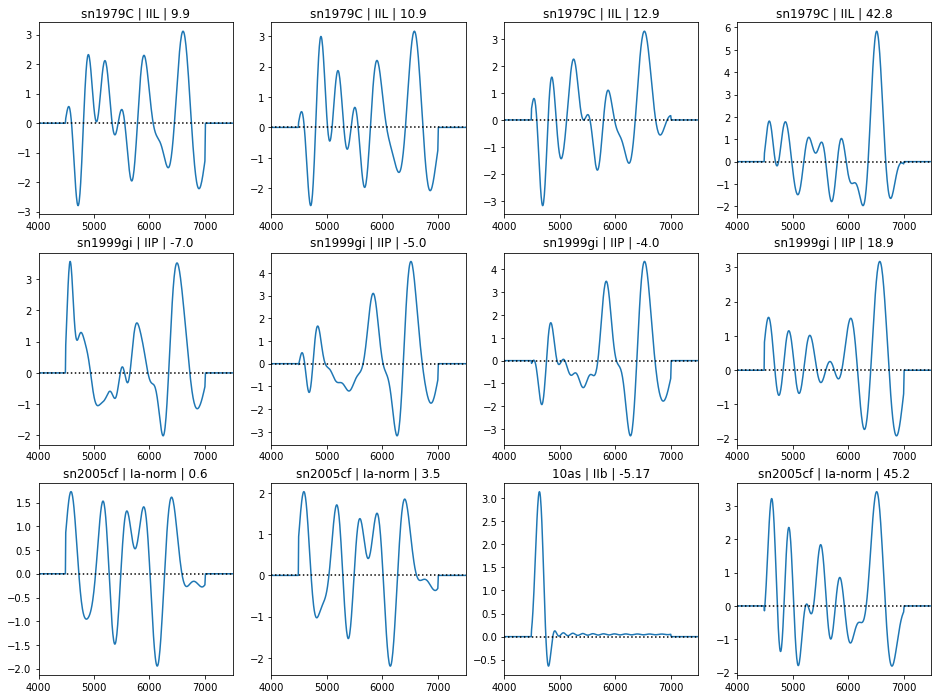

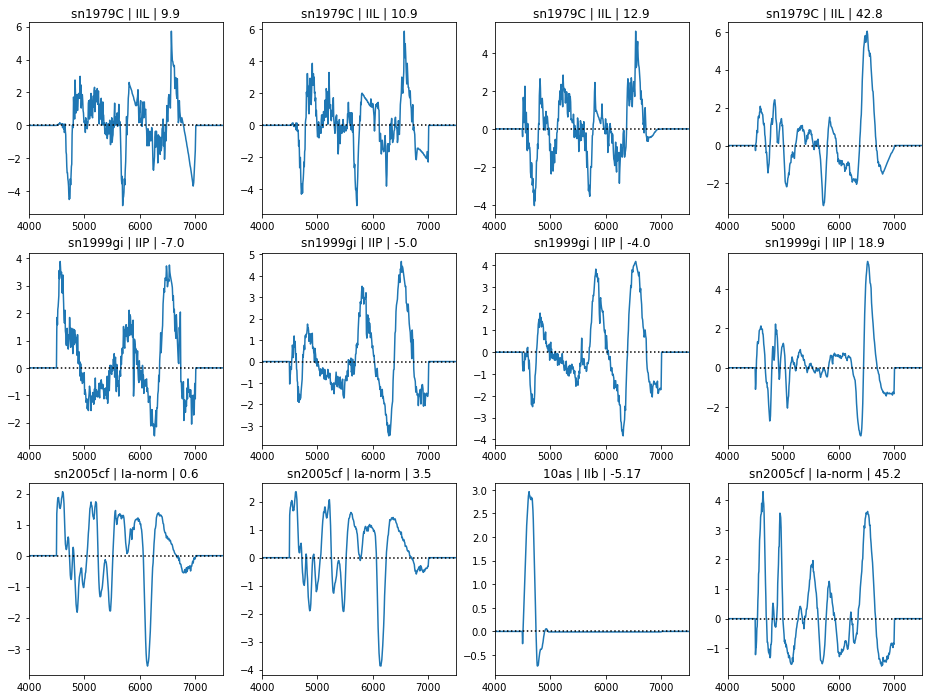

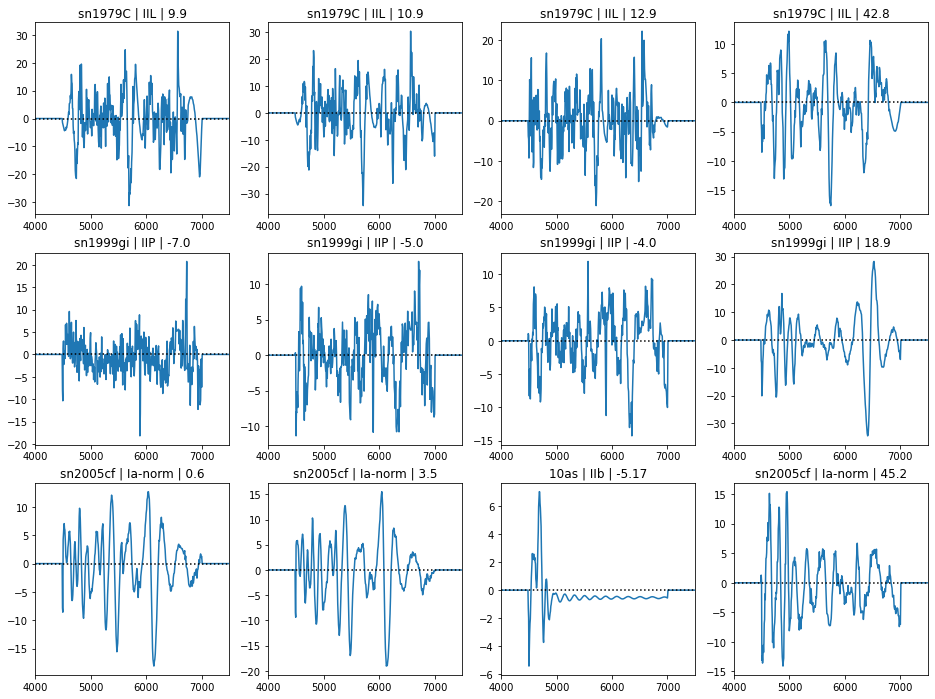

In [13]:
def get_denoised_data_with_noise(noise_scale):
    ic(noise_scale)
    
    df_P_trn_signal = pd.read_parquet(join(data_dir, "denoised/signal", "preprocessed_trn_set_signal_only.parquet"))
    df_P_tst_signal = pd.read_parquet(join(data_dir, "denoised/signal", "preprocessed_tst_set_signal_only.parquet"))
    
    df_P_trn_noise = pd.read_parquet(join(data_dir, "denoised/noise", "preprocessed_trn_set_noise_only.parquet"))
    df_P_tst_noise = pd.read_parquet(join(data_dir, "denoised/noise", "preprocessed_tst_set_noise_only.parquet"))
    
    data_trn_signal = dp.extract_dataframe(df_P_trn_signal)
    data_tst_signal = dp.extract_dataframe(df_P_tst_signal)
    
    data_trn_noise = dp.extract_dataframe(df_P_trn_noise)
    data_tst_noise = dp.extract_dataframe(df_P_tst_noise)
    
    _, _, flux_columns_trn_signal, _, _, _, fluxes_trn_signal = data_trn_signal
    _, _, flux_columns_tst_signal, _, _, _, fluxes_tst_signal = data_tst_signal
    
    _, _, flux_columns_trn_noise, _, _, _, fluxes_trn_noise = data_trn_noise
    _, _, flux_columns_tst_noise, _, _, _, fluxes_tst_noise = data_tst_noise
    
    df_trn = df_P_trn_signal.copy(deep=True)
    df_tst = df_P_tst_signal.copy(deep=True)
    
    df_trn[flux_columns_trn_signal] += noise_scale * fluxes_trn_noise
    df_tst[flux_columns_tst_signal] += noise_scale * fluxes_tst_noise
    
    return df_trn, df_tst


# plot_inds = np.array([0, 1, 2, 3])
xlim = (4000, 7500)

df_trn, df_tst = get_denoised_data_with_noise(0)
dplt.plot_specs(df_trn, plot_inds, xlim=xlim)

df_trn, df_tst = get_denoised_data_with_noise(1)
dplt.plot_specs(df_trn, plot_inds, xlim=xlim)

df_trn, df_tst = get_denoised_data_with_noise(10)
dplt.plot_specs(df_trn, plot_inds, xlim=xlim)

ic| noise_scale: 0
ic| noise_scale: 1
ic| noise_scale: 10


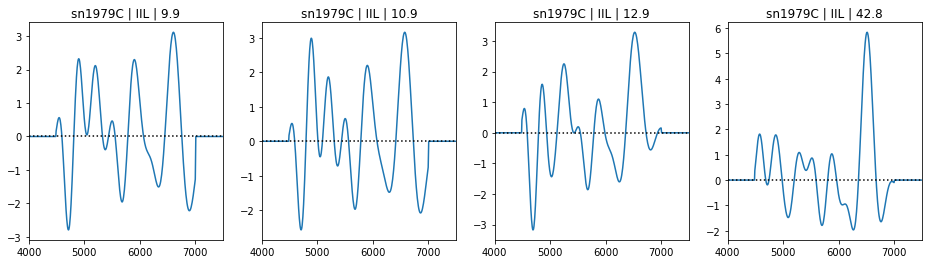

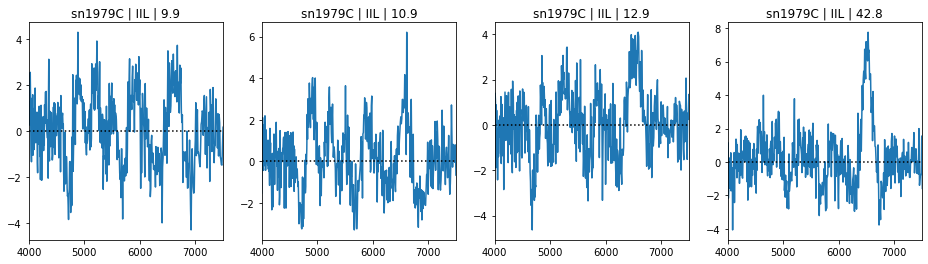

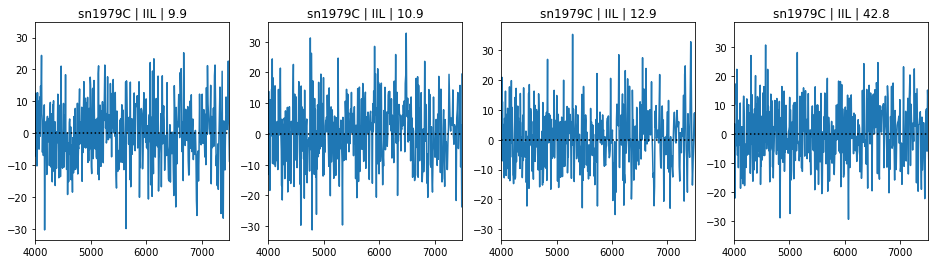

In [4]:
def get_denoised_data_gaussian_noise(noise_scale, rng):
    ic(noise_scale)
    
    data_dir = "/home/2649/repos/SCS/data/original_resolution/preprocessed_traintestsplit"
    df_P_trn = pd.read_parquet(join(data_dir, "denoised/signal", "preprocessed_trn_set_signal_only.parquet"))
    df_P_tst = pd.read_parquet(join(data_dir, "denoised/signal", "preprocessed_tst_set_signal_only.parquet"))
    
    data_trn = dp.extract_dataframe(df_P_trn)
    data_tst = dp.extract_dataframe(df_P_tst)
    
    _, _, flux_columns_trn, _, _, _, fluxes_trn = data_trn
    _, _, flux_columns_tst, _, _, _, fluxes_tst = data_tst
    
    noises_trn = stats.norm.rvs(loc=0, scale=noise_scale, size=fluxes_trn.shape, random_state=rng)
    noises_tst = stats.norm.rvs(loc=0, scale=noise_scale, size=fluxes_tst.shape, random_state=rng)
    
    df_trn = df_P_trn.copy(deep=True)
    df_tst = df_P_tst.copy(deep=True)
    
    df_trn[flux_columns_trn] += noises_trn
    df_tst[flux_columns_tst] += noises_tst

    return df_trn, df_tst


plot_inds = np.array([0, 1, 2, 3])
xlim = (4000, 7500)

df_trn, df_tst = get_denoised_data_gaussian_noise(0, rng=rng)
dplt.plot_specs(df_trn, plot_inds, xlim=xlim)

df_trn, df_tst = get_denoised_data_gaussian_noise(1, rng=rng)
dplt.plot_specs(df_trn, plot_inds, xlim=xlim)

df_trn, df_tst = get_denoised_data_gaussian_noise(10, rng=rng)
dplt.plot_specs(df_trn, plot_inds, xlim=xlim)

ic| noise_scale: 0
ic| noise_scale: 1
ic| noise_scale: 10


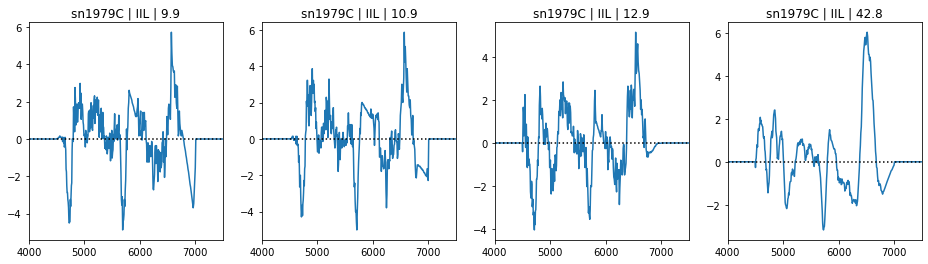

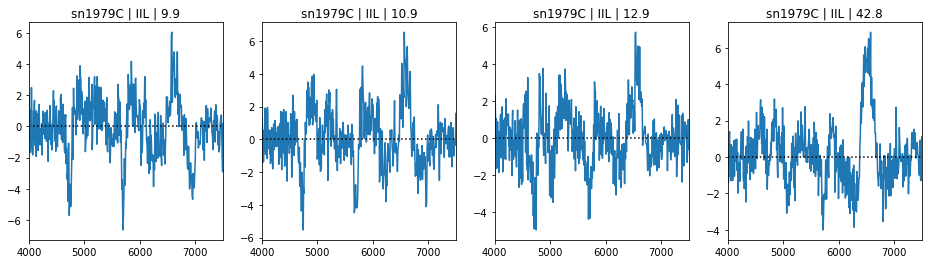

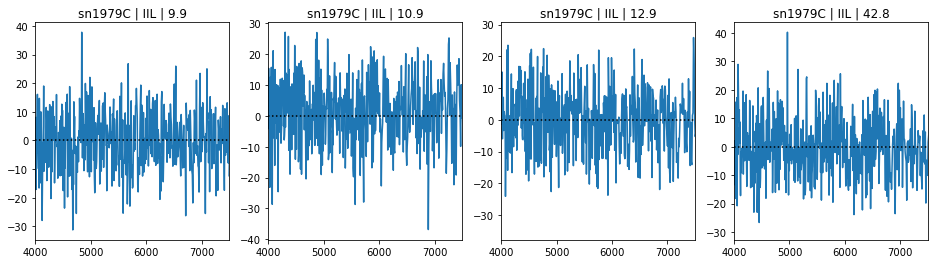

In [5]:
def get_data_gaussian_noise(noise_scale, rng):
    ic(noise_scale)
    
    data_dir = "/home/2649/repos/SCS/data/original_resolution/preprocessed_traintestsplit"
    df_P_trn = pd.read_parquet(join(data_dir, "data", "preprocessed_trn_set.parquet"))
    df_P_tst = pd.read_parquet(join(data_dir, "data", "preprocessed_tst_set.parquet"))
    
    data_trn = dp.extract_dataframe(df_P_trn)
    data_tst = dp.extract_dataframe(df_P_tst)
    
    _, _, flux_columns_trn, _, _, _, fluxes_trn = data_trn
    _, _, flux_columns_tst, _, _, _, fluxes_tst = data_tst
    
    noises_trn = stats.norm.rvs(loc=0, scale=noise_scale, size=fluxes_trn.shape, random_state=rng)
    noises_tst = stats.norm.rvs(loc=0, scale=noise_scale, size=fluxes_tst.shape, random_state=rng)
    
    df_trn = df_P_trn.copy(deep=True)
    df_tst = df_P_tst.copy(deep=True)
    
    df_trn[flux_columns_trn] += noises_trn
    df_tst[flux_columns_tst] += noises_tst

    return df_trn, df_tst


plot_inds = np.array([0, 1, 2, 3])
xlim = (4000, 7500)

df_trn, df_tst = get_data_gaussian_noise(0, rng=rng)
dplt.plot_specs(df_trn, plot_inds, xlim=xlim)

df_trn, df_tst = get_data_gaussian_noise(1, rng=rng)
dplt.plot_specs(df_trn, plot_inds, xlim=xlim)

df_trn, df_tst = get_data_gaussian_noise(10, rng=rng)
dplt.plot_specs(df_trn, plot_inds, xlim=xlim)

In [6]:
noise_scale_arr = np.arange(0, 20)

results_arr = []
for noise_scale in noise_scale_arr:
    ic(f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.")
    df_trn, df_tst = get_denoised_data_with_noise(noise_scale)
    
    # ic(f"Read in signal-only data. Add back in Gaussian noise.")
    # df_trn, df_tst = get_denoised_data_gaussian_noise(noise_scale, rng=rng)
    
    # ic(f"Read in data. Add in Gaussian noise.")
    # df_trn, df_tst = get_data_gaussian_noise(noise_scale, rng=rng)
    
    # ic("Data augmentation.")
    # wvl_range = (4500, 7000)
    # spike_scale = 3
    # max_spikes = 5
    # df_trn = da.augment(
    #     df_trn,
    #     rng,
    #     wvl_range=wvl_range,
    #     noise_scale=0,
    #     spike_scale=spike_scale,
    #     max_spikes=max_spikes,
    # )

    ic("Format data for training.")
    Xtrn, Ytrn, num_trn, num_wvl, num_classes = extract(df_trn)
    Xtst, Ytst, num_tst, num_wvl, num_classes = extract(df_tst)
    
    ic(Xtrn.shape, Ytrn.shape)
    ic(Xtst.shape, Ytst.shape)
    ic(num_trn)
    ic(num_tst)
    ic(num_wvl)
    ic(num_classes)

    ic("Generate and initialize the model.")
    input_shape = Xtrn.shape[1:]
    model = feed_forward.model(input_shape, num_classes, units=[1024, 1024, 1024])

    lr0 = 1e-5
    loss = CategoricalCrossentropy()
    acc = CategoricalAccuracy(name="ca")
    f1 = F1Score(num_classes=num_classes, average="macro", name="f1")

    optimizer = Nadam(learning_rate=lr0)
    model.compile(loss=loss, optimizer=optimizer, metrics=[acc, f1])

    early = callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=10,
        verbose=2,
        mode="min",
        restore_best_weights=True,
    )

    ic("Start model training.")
    history = model.fit(
        Xtrn,
        Ytrn,
        validation_data=(Xtst, Ytst),
        epochs=100,
        batch_size=32,
        verbose=0,
        callbacks=[early],
    )

    ic("Calculate model performance.")
    loss_trn, ca_trn, f1_trn = model.evaluate(x=Xtrn, y=Ytrn, verbose=0)
    loss_tst, ca_tst, f1_tst = model.evaluate(x=Xtst, y=Ytst, verbose=0)

    ic("Save model results.")
    results = np.array([noise_scale, loss_trn, ca_trn, f1_trn, loss_tst, ca_tst, f1_tst])
    results_arr.append(results)
    ic(noise_scale)
    ic(loss_trn, ca_trn, f1_trn)
    ic(loss_tst, ca_tst, f1_tst)

ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 0 multiples of noise to '
                                                                                                          'signal.')
ic| noise_scale: 0
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
2024-06-14 14:51:16.663843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 14:51:17.195878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532

Restoring model weights from the end of the best epoch: 23.
Epoch 33: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 0
ic| loss_trn: 0.27687638998031616
    ca_trn: 0.9438090324401855
    f1_trn: 0.8104233145713806
ic| loss_tst: 0.621940553188324
    ca_tst: 0.8288196325302124
    f1_tst: 0.437724769115448
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 1 multiples of noise to '
                                                                                                          'signal.')
ic| noise_scale: 1
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 1
ic| loss_trn: 0.21526984870433807
    ca_trn: 0.9632023572921753
    f1_trn: 0.8976946473121643
ic| loss_tst: 0.5858614444732666
    ca_tst: 0.8436382412910461
    f1_tst: 0.525492250919342
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 2 multiples of noise to '
                                                                                                          'signal.')
ic| noise_scale: 2
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 23.
Epoch 33: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 2
ic| loss_trn: 0.13441729545593262
    ca_trn: 0.9885628819465637
    f1_trn: 0.9820112586021423
ic| loss_tst: 0.5942652821540833
    ca_tst: 0.8395503163337708
    f1_tst: 0.535636842250824
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 3 multiples of noise to '
                                                                                                          'signal.')
ic| noise_scale: 3
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 21.
Epoch 31: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 3
ic| loss_trn: 0.13701127469539642
    ca_trn: 0.9850820302963257
    f1_trn: 0.9819239377975464
ic| loss_tst: 0.6570444703102112
    ca_tst: 0.824731707572937
    f1_tst: 0.49262070655822754
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 4 multiples of noise to '
                                                                                                          'signal.')
ic| noise_scale: 4
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 4
ic| loss_trn: 0.13164322078227997
    ca_trn: 0.9850820302963257
    f1_trn: 0.9870704412460327
ic| loss_tst: 0.7095000147819519
    ca_tst: 0.8088911771774292
    f1_tst: 0.4706078767776489
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 5 multiples of noise to '
                                                                                                          'signal.')
ic| noise_scale: 5
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 19.
Epoch 29: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 5
ic| loss_trn: 0.1399802565574646
    ca_trn: 0.9825957417488098
    f1_trn: 0.9762182831764221
ic| loss_tst: 0.7985783219337463
    ca_tst: 0.7961165308952332
    f1_tst: 0.4893653690814972
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 6 multiples of noise to '
                                                                                                          'signal.')
ic| noise_scale: 6
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 16.
Epoch 26: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 6
ic| loss_trn: 0.16457366943359375
    ca_trn: 0.9801093935966492
    f1_trn: 0.9818054437637329
ic| loss_tst: 0.7953432202339172
    ca_tst: 0.7823199033737183
    f1_tst: 0.4478711485862732
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 7 multiples of noise to '
                                                                                                          'signal.')
ic| noise_scale: 7
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 19.
Epoch 29: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 7
ic| loss_trn: 0.13339118659496307
    ca_trn: 0.9865738153457642
    f1_trn: 0.9875205755233765
ic| loss_tst: 0.8119279146194458
    ca_tst: 0.7858967781066895
    f1_tst: 0.4590720236301422
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 8 multiples of noise to '
                                                                                                          'signal.')
ic| noise_scale: 8
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 15.
Epoch 25: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 8
ic| loss_trn: 0.17247921228408813
    ca_trn: 0.9801093935966492
    f1_trn: 0.9728114604949951
ic| loss_tst: 0.8808996081352234
    ca_tst: 0.7756770849227905
    f1_tst: 0.4143780469894409
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 9 multiples of noise to '
                                                                                                          'signal.')
ic| noise_scale: 9
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 19.
Epoch 29: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 9
ic| loss_trn: 0.12044575065374374
    ca_trn: 0.9880656599998474
    f1_trn: 0.9896038770675659
ic| loss_tst: 0.9082942008972168
    ca_tst: 0.7664793133735657
    f1_tst: 0.4496064782142639
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 10 multiples of noise '
                                                                                                          'to signal.')
ic| noise_scale: 10
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 14.
Epoch 24: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 10
ic| loss_trn: 0.17505915462970734
    ca_trn: 0.9806066751480103
    f1_trn: 0.9818415641784668
ic| loss_tst: 0.919228732585907
    ca_tst: 0.772611141204834
    f1_tst: 0.41357260942459106
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 11 multiples of noise '
                                                                                                          'to signal.')
ic| noise_scale: 11
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 14.
Epoch 24: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 11
ic| loss_trn: 0.170125350356102
    ca_trn: 0.9816011786460876
    f1_trn: 0.9831160306930542
ic| loss_tst: 0.960010290145874
    ca_tst: 0.7613694667816162
    f1_tst: 0.42017877101898193
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 12 multiples of noise '
                                                                                                          'to signal.')
ic| noise_scale: 12
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 12
ic| loss_trn: 0.11346971243619919
    ca_trn: 0.9875683784484863
    f1_trn: 0.9888512492179871
ic| loss_tst: 0.918255090713501
    ca_tst: 0.768012285232544
    f1_tst: 0.43876469135284424
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 13 multiples of noise '
                                                                                                          'to signal.')
ic| noise_scale: 13
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 16.
Epoch 26: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 13
ic| loss_trn: 0.13649588823318481
    ca_trn: 0.9850820302963257
    f1_trn: 0.9859417676925659
ic| loss_tst: 0.9303033947944641
    ca_tst: 0.7572815418243408
    f1_tst: 0.42832210659980774
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 14 multiples of noise '
                                                                                                          'to signal.')
ic| noise_scale: 14
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 13.
Epoch 23: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 14
ic| loss_trn: 0.1760023981332779
    ca_trn: 0.9786176085472107
    f1_trn: 0.9810986518859863
ic| loss_tst: 1.0328706502914429
    ca_tst: 0.7465508580207825
    f1_tst: 0.4141218066215515
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 15 multiples of noise '
                                                                                                          'to signal.')
ic| noise_scale: 15
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 14.
Epoch 24: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 15
ic| loss_trn: 0.1442609280347824
    ca_trn: 0.9835902452468872
    f1_trn: 0.976870596408844
ic| loss_tst: 1.0000487565994263
    ca_tst: 0.7470618486404419
    f1_tst: 0.3758724629878998
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 16 multiples of noise '
                                                                                                          'to signal.')
ic| noise_scale: 16
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 13.
Epoch 23: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 16
ic| loss_trn: 0.16933318972587585
    ca_trn: 0.9791148900985718
    f1_trn: 0.9816566109657288
ic| loss_tst: 1.0421292781829834
    ca_tst: 0.7557485699653625
    f1_tst: 0.3637601435184479
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 17 multiples of noise '
                                                                                                          'to signal.')
ic| noise_scale: 17
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 15.
Epoch 25: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 17
ic| loss_trn: 0.13278697431087494
    ca_trn: 0.9855793118476868
    f1_trn: 0.9869396090507507
ic| loss_tst: 1.112617015838623
    ca_tst: 0.737864077091217
    f1_tst: 0.36543288826942444
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 18 multiples of noise '
                                                                                                          'to signal.')
ic| noise_scale: 18
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 15.
Epoch 25: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 18
ic| loss_trn: 0.12056659907102585
    ca_trn: 0.9895574450492859
    f1_trn: 0.9897879958152771
ic| loss_tst: 1.0984838008880615
    ca_tst: 0.733265221118927
    f1_tst: 0.37582555413246155
ic| f"Read in signal-only and noise-only data. Add back in {noise_scale} multiples of noise to signal.": ('Read in signal-only and noise-only data. Add back in 19 multiples of noise '
                                                                                                          'to signal.')
ic| noise_scale: 19
ic| 'Format data for training.'
ic| Xtrn.shape: (2011, 1024), Ytrn.shape: (2011, 16)
ic| Xtst.shape: (1957, 1024), Ytst.shape: (1957, 16)
ic| num_trn: 2011
ic| num_tst: 1957
ic| num_wvl: 1024
ic| num_classes: 16
ic| 'Generate and initialize the model.'
ic| 'Start model training.'


Restoring model weights from the end of the best epoch: 15.
Epoch 25: early stopping


ic| 'Calculate model performance.'
ic| 'Save model results.'
ic| noise_scale: 19
ic| loss_trn: 0.13250787556171417
    ca_trn: 0.9870710968971252
    f1_trn: 0.9875410795211792
ic| loss_tst: 1.147175669670105
    ca_tst: 0.7322432398796082
    f1_tst: 0.35149258375167847


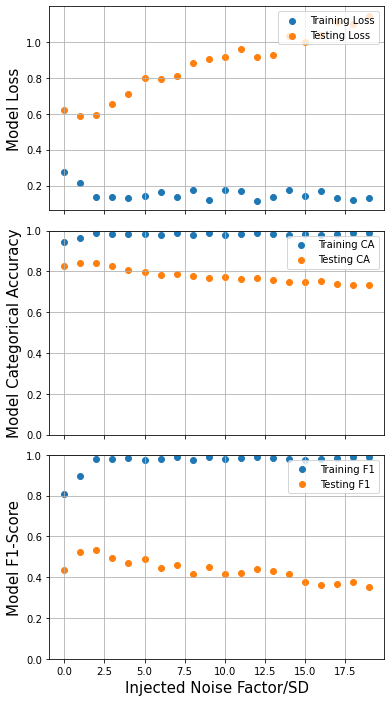

In [9]:
results_matrix = np.vstack(results_arr).T


fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=(6, 12))
plt.subplots_adjust(hspace=0.1)

axes[2].set_xlabel("Injected Noise Factor/SD", fontsize=15)

axes[0].set_ylabel("Model Loss", fontsize=15)
axes[1].set_ylabel("Model Categorical Accuracy", fontsize=15)
axes[2].set_ylabel("Model F1-Score", fontsize=15)

axes[1].set_ylim([0, 1])
axes[2].set_ylim([0, 1])

axes[0].scatter(results_matrix[0], results_matrix[1], c="tab:blue", ls="-", label="Training Loss")
axes[0].scatter(results_matrix[0], results_matrix[4], c="tab:orange", ls="-", label="Testing Loss")
axes[0].legend(loc="upper right")
axes[0].grid()

axes[1].scatter(results_matrix[0], results_matrix[2], c="tab:blue", ls="-", label="Training CA")
axes[1].scatter(results_matrix[0], results_matrix[5], c="tab:orange", ls="-", label="Testing CA")
axes[1].legend(loc="upper right")
axes[1].grid()

axes[2].scatter(results_matrix[0], results_matrix[3], c="tab:blue", ls="-", label="Training F1")
axes[2].scatter(results_matrix[0], results_matrix[6], c="tab:orange", ls="-", label="Testing F1")
axes[2].legend(loc="upper right")
axes[2].grid()

fig.savefig("/home/2649/repos/SCS/nb/results.jpg")
fig.show()